Dataset address:

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

# Import packages

In [47]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.metrics import precision_score, recall_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.decomposition import PCA
import statsmodels.api as sm 

# Import dataset

Import train and test data

In [48]:
path_train = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/train.csv'
path_test = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/test.csv'
df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [49]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Attain test Id

In [50]:
test_id = df_test['Id']

In [51]:
df_train.drop('Id', axis = 1, inplace = True)
df_test.drop('Id', axis = 1, inplace = True)

In [52]:
print(f"Number of rows and number of columns in the train dataset are {df_train.shape[0]} and {df_train.shape[1]}")
print(f"Number of rows and number of columns in the test dataset are {df_test.shape[0]} and {df_test.shape[1]}")

Number of rows and number of columns in the train dataset are 1460 and 80
Number of rows and number of columns in the test dataset are 1459 and 79


## Saleprice Feature Analysis

To analyze the response variable is to make sure the normality of y

In [53]:
def normal_test_plot(df, target):
    y = df[target]

    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(data=y,
                 kde=True, ax = ax1)
    ax1.set_title("Histogram for frequency of y")

    sm.qqplot(y, line='r', ax=ax2)

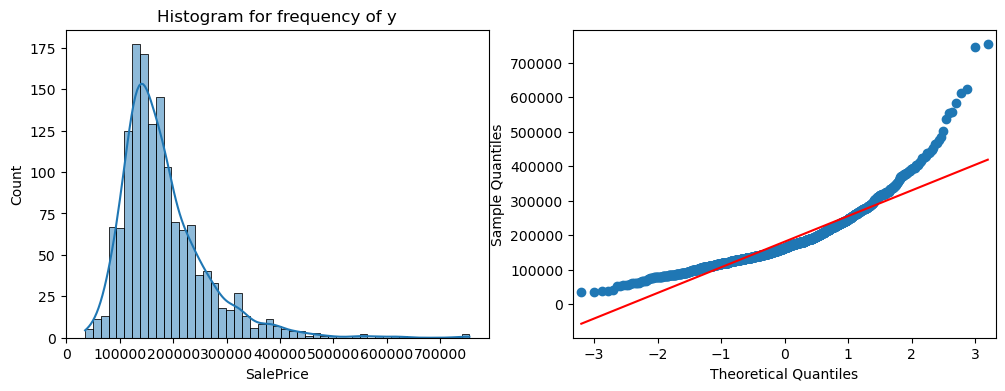

In [54]:
target = "SalePrice"
normal_test_plot(df_train, target)

From above, we know actually sale price is very left right-skewed, thus we need to adjust it to normal

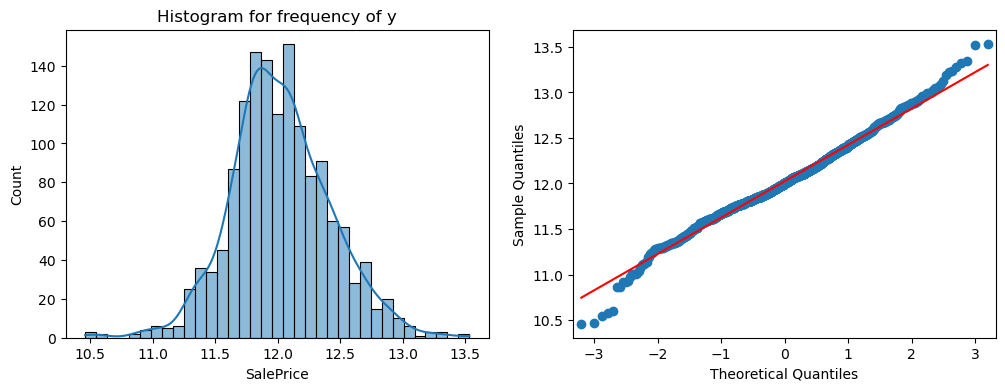

In [55]:
df_train[target] = np.log(df_train[target])
normal_test_plot(df_train, target)

# Exploratory Data analysis

## 1. Missing values

In [56]:
def null_table(df): # Give the NULL value table of the data
    null_count = df.isnull().sum()
    null_count = null_count[null_count != 0]
    null_percent = null_count / len(df)
    

    null_table = pd.DataFrame({'Var': null_count.index.to_list(),
                               'Null count': null_count.to_list(),
                               'Null Percentage': null_percent.to_list()})
    
    null_table.sort_values(by='Null Percentage', ascending=False, inplace=True)
    null_table.reset_index(drop=True, inplace=True)

    return null_table

In [57]:
null_table(df_train).head(10)

,Var,Null count,Null Percentage
0,PoolQC,1453,0.995205
1,MiscFeature,1406,0.963014
2,Alley,1369,0.937671
3,Fence,1179,0.807534
4,MasVnrType,872,0.597260
5,FireplaceQu,690,0.472603
6,LotFrontage,259,0.177397
7,GarageType,81,0.055479
8,GarageYrBlt,81,0.055479
9,GarageFinish,81,0.055479


In [58]:
null_table(df_test).head(10)

,Var,Null count,Null Percentage
0,PoolQC,1456,0.997944
1,MiscFeature,1408,0.965045
2,Alley,1352,0.926662
3,Fence,1169,0.801234
4,MasVnrType,894,0.612748
5,FireplaceQu,730,0.500343
6,LotFrontage,227,0.155586
7,GarageCond,78,0.053461
8,GarageYrBlt,78,0.053461
9,GarageQual,78,0.053461


Concat and get full dataset and make null value visualization

In [59]:
y_train = df_train[target]

df_full = pd.concat([df_train, df_test], keys = ['train', 'test']).reset_index(drop=True)
df_full.drop([target], axis = 1, inplace = True)
print(f"Total size is {df_full.shape}")

Total size is (2919, 79)


Make plot to show the total missing values

Text(-2.7, 0.3, '0.3')

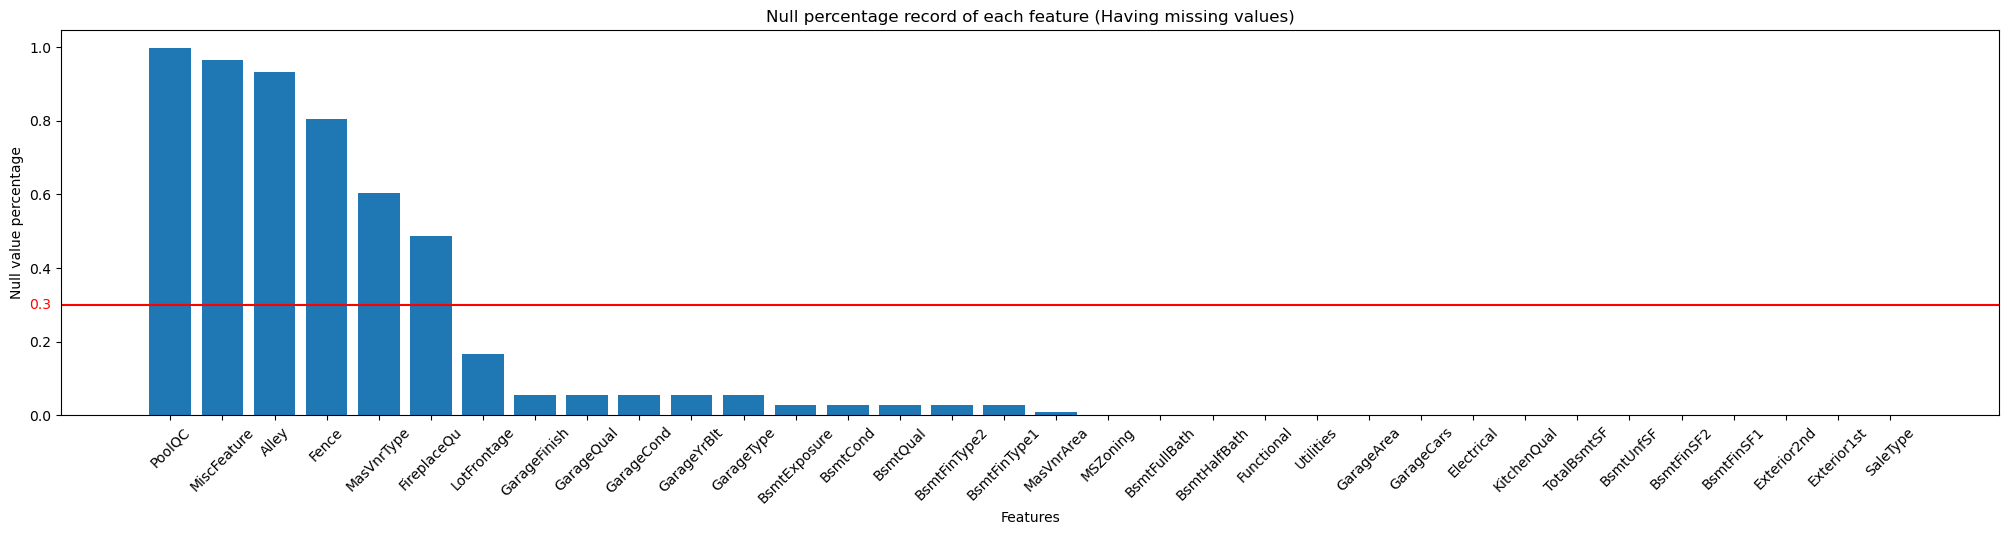

In [60]:
df = null_table(df_full)
fig, ax = plt.subplots(figsize=(25,5))
ax.bar(x=df['Var'], height=df['Null Percentage'])
ax.set_title('Null percentage record of each feature (Having missing values)')
ax.set_xlabel('Features')
ax.set_ylabel('Null value percentage')
_ = ax.set_xticks(df['Var'],df['Var'], rotation=45)

ax.axhline(y=0.3, color='red')
ax.text(-2.7, 0.3, 0.3, color = "red", 
        ha='left', va='center')

## 2. Analyze Numerical and Categorical variables

Select numerical and categorical features

In [61]:
df_num = df_train.select_dtypes(exclude=object)
df_cat = df_train.select_dtypes(include=object)
print(f"Number of numeric features: {df_num.shape[1]}")
print(f"Number of categorical features: {df_cat.shape[1]}")

Number of numeric features: 37
Number of categorical features: 43


### 2.1 See the correlation of numeric variables and the target variables

In [62]:
corr_num = df_num.corr()[target].sort_values(ascending=False)[1:].head(10)
corr_num

OverallQual     0.817184
GrLivArea       0.700927
GarageCars      0.680625
GarageArea      0.650888
TotalBsmtSF     0.612134
1stFlrSF        0.596981
FullBath        0.594771
YearBuilt       0.586570
YearRemodAdd    0.565608
GarageYrBlt     0.541073
Name: SalePrice, dtype: float64

#### 1) Analyze relationship between target & GrLivArea 

In [63]:
def corr_plot(df,feature):
    x = df[feature]
    y = df[target]

    fig, ax = plt.subplots(figsize=(6,3))
    ax.scatter(x,y, color ='red', alpha = 0.4)
    a, b = np.polyfit(x,y,1)
    ax.plot(x, a*x+b)

    ax.set_title(f"Relationship between {feature} & Saleprice")
    ax.set_xlabel(f"{feature}")
    ax.set_ylabel("Saleprice")

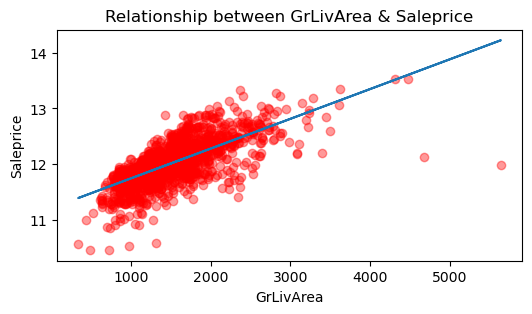

In [64]:
corr_plot(df_train,'GrLivArea')

Remove 2 outliers

In [65]:
df_train = df_train[df_train['GrLivArea'] <= 4500].reset_index(drop=True)
df_train.shape

(1458, 80)

#### 2) Analyze the correlation between target & GarageArea

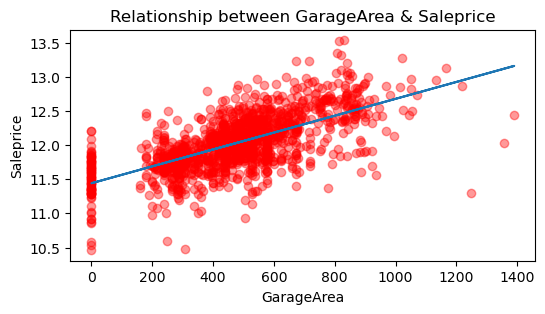

In [66]:
corr_plot(df_train,'GarageArea')

In [67]:
df_train = df_train[(df_train['GarageArea'] < 1248)].reset_index(drop=True)
df_train.shape

(1455, 80)

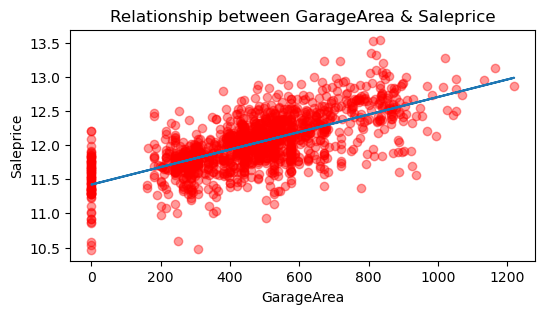

In [68]:
corr_plot(df_train,'GarageArea')

#### 3) Analyze relationship between target & TotalBsmtSF

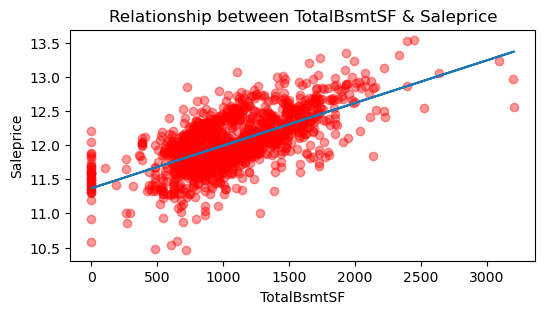

In [69]:
corr_plot(df_train,'TotalBsmtSF')  

#### 4) Correlation between target & 1stFlrSF

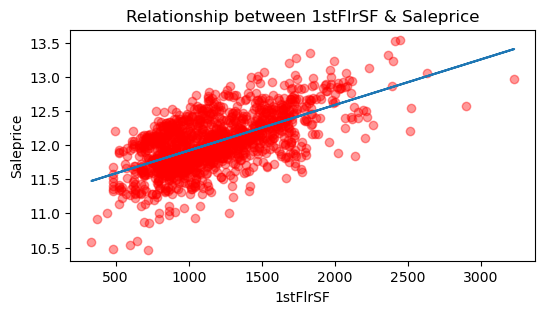

In [70]:
corr_plot(df_train,'1stFlrSF')

### 2.2 Explore categorical variables and the target variables

In [71]:
df_train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247694
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109011
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317167
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849398
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,12.072541
1451,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,12.254863
1452,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,12.493130
1453,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,11.864462


In [72]:
y_train = df_train[target].reset_index(drop=True)
print(y_train.shape)

(1455,)


# Feature Engineering

## 1. Combine test and train dataset

In [73]:
y_train = df_train[target].reset_index(drop=True)
train = df_train.drop(target, axis=1)
test = df_test.copy()

df_full = pd.concat([train, test], keys=['train','test'])

In [74]:
print(y_train.shape)
print(train.shape)
print(test.shape)

(1455,)
(1455, 79)
(1459, 79)


In [75]:
df_full.shape

(2914, 79)

## 2. DataType transformation

In [76]:
df_full['MSSubClass'].astype('str')
df_full['MoSold'].astype('str')
df_full['YrSold'].astype('str')

train  0       2008
       1       2007
       2       2008
       3       2006
       4       2008
               ... 
test   1454    2006
       1455    2006
       1456    2006
       1457    2006
       1458    2006
Name: YrSold, Length: 2914, dtype: object

## 3. Remove unbalanced data

In [77]:
null_tb = null_table(df_full)
null_tb

,Var,Null count,Null Percentage
0,PoolQC,2905,0.996911
1,MiscFeature,2810,0.964310
2,Alley,2716,0.932052
3,Fence,2343,0.804049
4,MasVnrType,1765,0.605697
5,FireplaceQu,1419,0.486960
6,LotFrontage,485,0.166438
7,GarageFinish,159,0.054564
8,GarageQual,159,0.054564
9,GarageCond,159,0.054564


In [78]:
drop_lst = null_tb[null_tb['Null Percentage'] > 0.8]['Var'].to_list()
df_full.drop(columns=drop_lst, inplace=True)

## 4. Fill the NaN value with 'None'

In [79]:
# MasVnrType: None
# FireplaceQu: No Fireplace
# GarageFinish: No garage
# GarageQual: No garage
# GarageType: No garage
# BsmtCond: No basement
# BsmtExposure: No basement
# BsmtQual: No basement
# BsmtFinType2: No basement
# BsmtFinType1: No basement
nan_feature = ['MasVnrType', 'FireplaceQu','GarageFinish', 
               'GarageCond','GarageQual', 'GarageType', 'BsmtCond', 
               'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1']
for feature in nan_feature:
    df_full[feature].fillna('None',inplace=True)

In [80]:
print(df_full.dtypes.to_string())

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1       float64
BsmtFinType2      object
BsmtFinSF2       float64
BsmtUnfSF        float64
TotalBsmtSF      float64
Heating           object
HeatingQC         object
CentralAir        object


## 5. Fill missing values

In [81]:
null_tb = null_table(df_full)
null_tb

,Var,Null count,Null Percentage
0,LotFrontage,485,0.166438
1,GarageYrBlt,159,0.054564
2,MasVnrArea,23,0.007893
3,MSZoning,4,0.001373
4,BsmtFullBath,2,0.000686
5,Utilities,2,0.000686
6,Functional,2,0.000686
7,BsmtHalfBath,2,0.000686
8,GarageArea,1,0.000343
9,GarageCars,1,0.000343


In [82]:
'''
LotFrontage: median
GarageYrBlt: median
MasVnrArea: median
MSZoning: mode
BsmtFullBath: 0
Utilities: mode
Functional: Typ
BsmtHalfBath: 0
GarageArea: 0
GarageCars: 0
KitchenQual: TA
TotalBsmtSF: 0
Electrical: mode
BsmtUnfSF: median
BsmtFinSF2: median
BsmtFinSF1: median
Exterior2nd: mode
Exterior1st: mode
SaleType: mode
'''

def fill_missing(df):
    median_feature = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'BsmtUnfSF', 'BsmtFinSF2','BsmtFinSF1']
    mode_feature = ['MSZoning', 'Utilities', 'Electrical', 'Exterior2nd', 'Exterior1st', 'SaleType']
    zero_feature = ['BsmtFullBath','BsmtHalfBath', 'GarageArea', 'GarageCars', 'TotalBsmtSF']

    df['Functional'].fillna('Typ', inplace=True)
    df['KitchenQual'].fillna('TA', inplace=True)

    for f in median_feature:
        df[f] = df[f].fillna(df[f].median(skipna=True))

    for f in mode_feature:
        df[f] = df[f].fillna(df[f].mode(dropna=True)[0])

    for f in zero_feature:
        df[f] = df[f].fillna(0)
    
    return df

In [83]:
df_full = fill_missing(df_full)

In [84]:
null_table(df_full)

,Var,Null count,Null Percentage


No missing value now.

## 6. Feature creation

In [85]:
'''
GrLivArea = 1stFlrSF + 2ndFlrSF
TotalArea = TotalBsmtSF + GrLivArea
Total_bathrooms = basement_fullbath + basement_halfbath*0.5 + fullbath + halfbath*0.5
'''
def newfeatures(df):
    df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
    df['Has2ndFloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
    df['HasBsmt'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)


    ## Creating new important features
    df['TotalsF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
    df['TotalBath'] = df['BsmtFullBath'] + df['BsmtHalfBath'] * 0.5 + df['FullBath'] + df['HalfBath'] * 0.5
    df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']

    return df

In [86]:
df_full.shape

(2914, 75)

In [87]:
df_full = newfeatures(df_full)

In [88]:
df_full.shape

(2914, 82)

## 7. Encode categorical features

In [89]:
df_full = pd.get_dummies(df_full).reset_index(drop=True)
df_full.shape

(2914, 291)

# Train test split

In [90]:
X_train, X_test = df_full.iloc[:len(y_train), :], df_full.iloc[len(y_train):, :]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(1455, 291)
(1459, 291)
(1455,)


In [91]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

## PCA

In [151]:
pca_ = PCA(n_components=291)
X_train_scaled_pca = pca_.fit_transform(X_train_scaled)

Text(226, 0.9988048887876506, '(226,0.9988)')

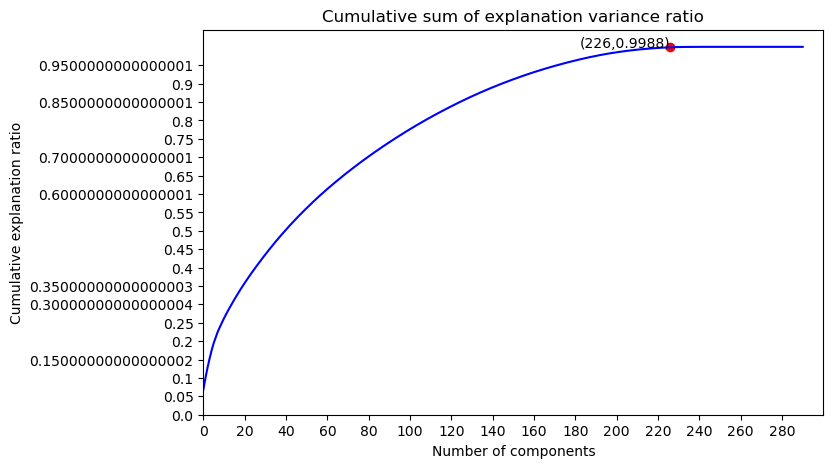

In [154]:
var_ratio = pca_.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)
x = list(range(len(var_ratio)))

fig, ax = plt.subplots(figsize=(8,5))
y1 = cum_var_ratio[cum_var_ratio < 0.999][-1]
x1 = list(cum_var_ratio).index(y1)
ax.plot(x1,y1,'or')

ax.plot(x, cum_var_ratio, color='blue')
ax.set_title('Cumulative sum of explanation variance ratio')
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explanation ratio')
_ = ax.set_xticks(x[::20], x[::20])
_ = ax.set_yticks(np.arange(0,1,0.05), np.arange(0,1,0.05))
ax.set_xlim(0,300)

ax.text(x1,y1, f"({x1},{y1:.4f})", ha='right')

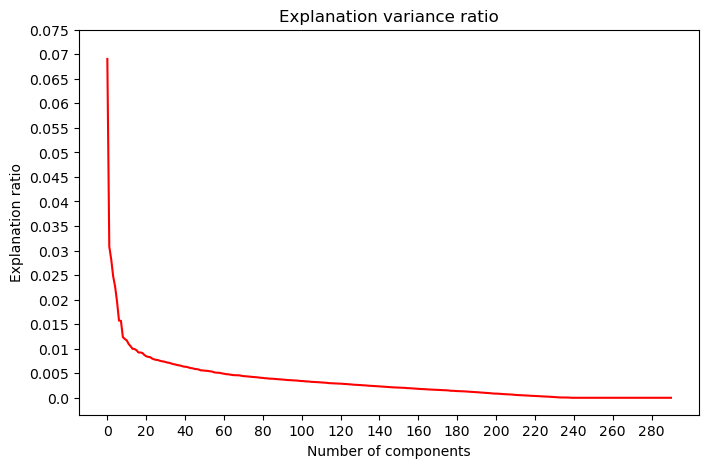

In [117]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(x, var_ratio, color='red')
ax.set_title('Explanation variance ratio')
ax.set_xlabel('Number of components')
ax.set_ylabel('Explanation ratio')
_ = ax.set_xticks(x[::20], x[::20])
_ = ax.set_yticks(np.arange(0,0.08,0.005), np.arange(0,0.08,0.005))

In [155]:
pca_ = PCA(n_components=226)
X_train_scaled_pca = pca_.fit_transform(X_train_scaled)
X_test_scaled_pca = pca_.transform(X_test_scaled)

# Training: Hyperparameter tuning, searching and model selection

## Evaluation metric: rmse

In [156]:
def rmse_score(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

## 1. Lasso regression

In [157]:
ls = Lasso(random_state=42,
           warm_start=True)
hyper = {'alpha': np.arange(0.001, 0.1, 0.001)} # np.arange(0.001, 0.1, 0.001)

lscv = GridSearchCV(ls, hyper, 
                    scoring=rmse_scorer,
                    cv = 5)
lscv.fit(X_train_scaled_pca, y_train)

ls_optimal = lscv.best_estimator_ # Optimal model
ls_optimal_score = -lscv.best_score_ # Optimal score

print(f"The best RMSE with parameters: {lscv.best_params_}")
print(f"Lasso best cross-validation RMSE:, {ls_optimal_score}")

The best RMSE with parameters: {'alpha': 0.002}
Lasso best cross-validation RMSE:, 0.11989094063998473


## 2. Ridge regression

In [158]:
ridge = Ridge(random_state=42)
hyper = {'alpha': np.arange(248, 250, 0.01)} # 247, 249, 0.001

ridgecv = GridSearchCV(ridge, hyper, 
                       scoring=rmse_scorer)
ridgecv.fit(X_train_scaled_pca, y_train)

ridge_optimal = ridgecv.best_estimator_
ridge_optimal_score = -ridgecv.best_score_

print(f"The best RMSE with parameters: {ridgecv.best_params_}")
print("Ridge regression best cross-validation RMSE:", ridge_optimal_score)

The best RMSE with parameters: {'alpha': 249.9899999999982}
Ridge regression best cross-validation RMSE: 0.11810234175826699


## 3. Elastic-net regression

In [159]:
enet = ElasticNet(random_state=42,
                  warm_start=True)
hyper = {'alpha': np.arange(0.01, 0.3, 0.01),
         'l1_ratio': np.arange(0.01, 1, 0.1)}

enetcv = GridSearchCV(enet, hyper, 
                      scoring=rmse_scorer)
enetcv.fit(X_train_scaled_pca, y_train)

enet_optimal = enetcv.best_estimator_
enet_optimal_score = -enetcv.best_score_

print(f"The best RMSE with parameters: {enetcv.best_params_}")
print("ElasticNet best cross-validation RMSE:", enet_optimal_score)

The best RMSE with parameters: {'alpha': 0.13, 'l1_ratio': 0.01}
ElasticNet best cross-validation RMSE: 0.11821308904023668


## 4. Decision tree regression

In [161]:
tree = DecisionTreeRegressor(random_state=42)
hyper = {'max_depth': np.arange(1, 20)} # 5, 20, 1

treecv = GridSearchCV(tree, hyper, 
                      scoring=rmse_scorer)
treecv.fit(X_train_scaled_pca, y_train)

tree_optimal = treecv.best_estimator_
tree_optimal_score = -treecv.best_score_

print(f"The best RMSE with parameters: {treecv.best_params_}")
print("Decision tree best cross-validation RMSE:", tree_optimal_score)

The best RMSE with parameters: {'max_depth': 4}
Decision tree best cross-validation RMSE: 0.1866879898569128


## 5. Random forest regression

In [162]:
rf = RandomForestRegressor(random_state=42,
                           warm_start=True)
hyper = {'n_estimators': np.arange(1, 20, 2),
         'max_depth': np.arange(1, 20, 3)} # 5, 20, 1

rfcv = GridSearchCV(rf, hyper, 
                      scoring=rmse_scorer)
rfcv.fit(X_train_scaled_pca, y_train)

rf_optimal = rfcv.best_estimator_
rf_optimal_score = -rfcv.best_score_

print(f"The best RMSE with parameters: {rfcv.best_params_}")
print("Random forest best cross-validation RMSE:", rf_optimal_score)

The best RMSE with parameters: {'max_depth': 19, 'n_estimators': 19}
Random forest best cross-validation RMSE: 0.15007844854292154


## 6. XGBRegressor

In [163]:
xgbrg = xgb.XGBRegressor(random_state=42)

hyper = {'n_estimators': np.arange(1, 30, 1),
         'max_depth': np.arange(1, 20, 3)} # 5, 20, 1

xgbrgcv = GridSearchCV(xgbrg, hyper, 
                      scoring=rmse_scorer)
xgbrgcv.fit(X_train_scaled_pca, y_train)

xgbrg_optimal = xgbrgcv.best_estimator_
xgbrg_optimal_score = -xgbrgcv.best_score_

print(f"The best RMSE with parameters: {xgbrgcv.best_params_}")
print("xgb regressor best cross-validation RMSE:", xgbrg_optimal_score)

The best RMSE with parameters: {'max_depth': 4, 'n_estimators': 29}
xgb regressor best cross-validation RMSE: 0.14916596899439954


In [164]:
models = ['Lasso', 'Ridge', 'Elastic-net', 'Decision tree', 'Random forest', 'xgb']
rmse = [ls_optimal_score, ridge_optimal_score, enet_optimal_score, tree_optimal_score, rf_optimal_score, xgbrg_optimal_score]

score_tb = pd.DataFrame({'Models': models, 
                         'Optimal_RMSE': rmse})

print(score_tb)

          Models  Optimal_RMSE
0          Lasso      0.119891
1          Ridge      0.118102
2    Elastic-net      0.118213
3  Decision tree      0.186688
4  Random forest      0.150078
5            xgb      0.149166


# Submission

In [165]:
y_pred = np.exp(enet_optimal.predict(X_test_scaled_pca))
output = pd.DataFrame({'Id': test_id, 'SalePrice': y_pred})

In [166]:
save_path = '/Users/yuwensun/Documents/编程/Kaggle/Kaggle_houseprice_prediction/submission.csv'
output.to_csv(save_path, index=False)